In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Get the stock quote 
df = web.DataReader('^NSEBANK', data_source='yahoo', start='2015-01-01', end='2020-08-17') 
#Show the data 
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-08-04,21576.349609,21057.750000,21248.250000,21490.500000,0.0,21490.500000
2020-08-05,21936.500000,21448.400391,21686.849609,21509.949219,338800.0,21509.949219
2020-08-06,21926.550781,21370.300781,21644.250000,21642.599609,386600.0,21642.599609
2020-08-07,21787.250000,21451.300781,21620.250000,21754.000000,378600.0,21754.000000
2020-08-10,22071.949219,21795.099609,21824.900391,21900.250000,261800.0,21900.250000
2020-08-11,22277.599609,22039.849609,22050.199219,22227.199219,377900.0,22227.199219
2020-08-12,22326.550781,21990.199219,22135.949219,22264.000000,507500.0,22264.000000
2020-08-13,22439.949219,22139.599609,22395.199219,22196.349609,289100.0,22196.349609
2020-08-14,22334.949219,21459.099609,22334.949219,21679.400391,318800.0,21679.400391


In [3]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [4]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [5]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(120,len(train_data)):
    x_train.append(train_data[i-120:i,0])
    y_train.append(train_data[i,0])

In [6]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [7]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [8]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [9]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

768/768 [==============================] - 61s 80ms/step - loss: 0.0039 0s - loss: 0.0


In [11]:
#Test data set
test_data = scaled_data[training_data_len - 120: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(120,len(test_data)):
    x_test.append(test_data[i-120:i,0])

In [12]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [13]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [14]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [15]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1605.0174542993939

C:\Users\Abhi\.conda\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


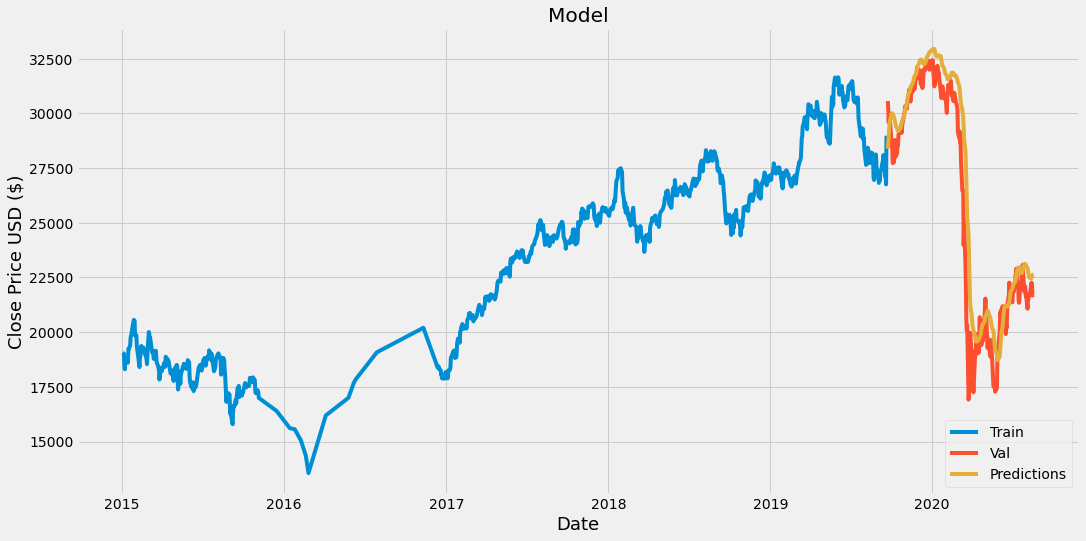

In [16]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [17]:
#Get the quote
apple_quote = web.DataReader('^NSEBANK', data_source='yahoo', start='2015-01-01', end='2020-08-17')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 120 day closing price 
last_120_days = new_df[-120:].values
#Scale the data to be values between 0 and 1
last_120_days_scaled = scaler.transform(last_120_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_120_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[22634.54]]


In [18]:
#bank_nifty = web.DataReader('^NSEBANK', data_source='yahoo', start='2020-07-13', end='2020-07-15')
#print(bank_nifty['Close'])